__Chapter 6 - Learning Best Practices for Model Evaluation and Hyperparameter Tuning__

1. [Streamlining workflows with pipelines](#Streamlining-workflows-with-pipelines)
    1. [](#)
1. [Combining transformers and estimators in a pipeline](#Combining-transformers-and-estimators-in-a-pipeline)
1. [Assessing model performance with cross-validation](#Assessing-model-performance-with-cross-validation)
1. [Debugging algorithms with learning an validation curves](#Debugging-algorithms-with-learning-an-validation-curves)
1. [](#)
1. [](#)


In [1]:
# Standard libary and settings
import os
import sys
import warnings; warnings.simplefilter('ignore')
dataPath = os.path.abspath(os.path.join('../../Data'))
modulePath = os.path.abspath(os.path.join('../../CustomModules'))
sys.path.append(modulePath) if modulePath not in sys.path else None
from IPython.core.display import display, HTML; display(HTML("<style>.container { width:95% !important; }</style>"))


# Data extensions and settings
import numpy as np
np.set_printoptions(threshold = np.inf, suppress = True)
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.6f}'.format


# Modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm


# Visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt


# Custom extensions and settings
from quickplot import qp, qpUtil, qpStyle
from mlTools import powerGridSearch
sns.set(rc = qpStyle.rcGrey)


# Magic functions
%matplotlib inline

<a id = 'Streamlining-workflows-with-pipelines'></a>

# Streamlining workflows with pipelines

The Pipeline class is handy when we need to fit a model and apply an arbitrary number of transformation steps, including features scaling, feature selection, and/or feature extraction.

In [2]:
# Load and inspect data

cancer_data = datasets.load_breast_cancer()

df_cancer = pd.DataFrame(data = np.c_[cancer_data.target, cancer_data.data], columns = ['Label'] + list(cancer_data.feature_names))
df_cancer[:5]


,Label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.000000,17.990000,10.380000,122.800000,"1,001.000000",0.118400,0.277600,0.300100,0.147100,0.241900,...,25.380000,17.330000,184.600000,"2,019.000000",0.162200,0.665600,0.711900,0.265400,0.460100,0.118900
1,0.000000,20.570000,17.770000,132.900000,"1,326.000000",0.084740,0.078640,0.086900,0.070170,0.181200,...,24.990000,23.410000,158.800000,"1,956.000000",0.123800,0.186600,0.241600,0.186000,0.275000,0.089020
2,0.000000,19.690000,21.250000,130.000000,"1,203.000000",0.109600,0.159900,0.197400,0.127900,0.206900,...,23.570000,25.530000,152.500000,"1,709.000000",0.144400,0.424500,0.450400,0.243000,0.361300,0.087580
3,0.000000,11.420000,20.380000,77.580000,386.100000,0.142500,0.283900,0.241400,0.105200,0.259700,...,14.910000,26.500000,98.870000,567.700000,0.209800,0.866300,0.686900,0.257500,0.663800,0.173000
4,0.000000,20.290000,14.340000,135.100000,"1,297.000000",0.100300,0.132800,0.198000,0.104300,0.180900,...,22.540000,16.670000,152.200000,"1,575.000000",0.137400,0.205000,0.400000,0.162500,0.236400,0.076780


In [3]:
#

X = df_cancer.iloc[:, 1:].values
y = df_cancer.iloc[:, 0].values
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
print('Unique class labels: {0}'.format(np.unique(y)))


Unique class labels: [0 1]


In [4]:
#

XTrain, XTest, yTrain, yTest = \
                model_selection.train_test_split(X, y, test_size = 0.20
                                                ,stratify = y, random_state = 1)


<a id = 'Combining-transformers-and-estimators-in-a-pipeline'></a>

# Combining transformers and estimators in a pipeline

Combine data standardizations, Principal Component Analysis and Logistic Regression into one pipeline.

In [5]:
#

pipe = pipeline.make_pipeline(preprocessing.StandardScaler()
                                ,decomposition.PCA(n_components = 2)
                                ,linear_model.LogisticRegression(random_state = 1))
pipe.fit(XTrain, yTrain)
yPredTest = pipe.predict(XTest)
print('Test set accuracy: {:.3f}'.format(pipe.score(XTest, yTest)))


Test set accuracy: 0.956


> Remarks - make_pipeline takes in an arbitrary number of transformers, which are objects that include fit and transform methods. These are followed by an algorithm of our choice. In the pipeline, the data is passed to each step, where a fit and transform method is called before being passed to the next step. Once these steps are completed, the pipeline is equiped with a fit and predict method that it inherits from the estimator that we put in the pipeline.

<a id = 'Assessing-model-performance-with-cross-validation'></a>

# Assessing model performance with cross-validation

Testing a model on data it hasn't seen before is an essential step in truly evaluating a model's quality. Cross-validation (CV) is a technique that is useful for finding an acceptable bias/variance trade-off. Two common variation of CV are holdout CV and k-fold CV.

__The holdout method__

The holdout method involves separating the data set into three parts: training, testing and validation. The train and validations set are used to tune the parameters of the model. Upon finding a desirable model, the final step is to evaluate the model on the test data, which is has not seen up to this point. This simple and intuitive approach has a disadvantage in that it can be very sensitive to how the data is partitioned. k-fold CV is generally a more robust alternative.

__k-fold cross-validation__

With k-fold CV, the data is split into $k$ folds. $k$-1 folds are used for training the model and the last fold evaluates the model performance. this process is repeated $k$ times, using a different slice of data for the validation set each time. We are left with $k$ separate estimates of model performance. By default, this process samples all data without replacement, so we are certain that each data point is used in each iteration and each data point is used in the validation set once. Evaluating CV involves reviewing the mean and standard deviation of the $k$ scores.

The best model is trained on the full training data set, and then evaluated one last time using the test data that was set aside, just as we did with the holdout method.

__Stratified k-fold__

Stratified k-fold CV is a variation of k-fold CV that ensures that class proportions are preserved in each folder to ensure that each fold is representative of the class proportions across the entire data set.

In [6]:
# Stratified k-fold example, verbose example

kfold = model_selection.StratifiedKFold(n_splits = 10
                                        ,random_state = 1).split(XTrain
                                                                 ,yTrain)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe.fit(XTrain[train], yTrain[train])
    score = pipe.score(XTrain[test], yTrain[test])
    scores.append(score)
    print('Fold: {:.0f}, Class dist.: {}, Acc: {:.3f}'.format(k + 1
                                                             ,np.bincount(yTrain[train])
                                                             ,score))

Fold: 1, Class dist.: [153 256], Acc: 0.978
Fold: 2, Class dist.: [153 256], Acc: 0.935
Fold: 3, Class dist.: [153 256], Acc: 0.957
Fold: 4, Class dist.: [153 256], Acc: 0.935
Fold: 5, Class dist.: [153 256], Acc: 0.913
Fold: 6, Class dist.: [153 257], Acc: 0.956
Fold: 7, Class dist.: [153 257], Acc: 0.933
Fold: 8, Class dist.: [153 257], Acc: 0.956
Fold: 9, Class dist.: [153 257], Acc: 0.933
Fold: 10, Class dist.: [153 257], Acc: 0.956


In [7]:
#

print('\n CV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores)
                                                 ,np.std(scores)))



 CV accuracy: 0.945 +/- 0.018


In [8]:
# Stratified KFold, succinct example using cross_val_score

scores = model_selection.cross_val_score(estimator = pipe
                                        ,X = XTrain
                                        ,y = yTrain
                                        ,cv = 10
                                        ,n_jobs = 1)
print('CV accuracy scores: {}'.format(scores))
print('\n CV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores)
                                                 ,np.std(scores)))


CV accuracy scores: [0.97826087 0.93478261 0.95652174 0.93478261 0.91304348 0.95555556
 0.93333333 0.95555556 0.93333333 0.95555556]

 CV accuracy: 0.945 +/- 0.018


> Remarks - automatically apply stratificaiton?

<a id = 'Debugging-algorithms-with-learning-an-validation-curves'></a>

# Debugging algorithms with learning an validation curves

Learning and validation curves are useful for determining whether an algorithm has a problem with overfitting or underfitting.

In [9]:
# 

pipe = pipeline.make_pipeline(preprocessing.StandardScaler()
                                ,linear_model.LogisticRegression(penalty = 'l2'
                                ,random_state = 1)
                            )
train_sizes, train_scores, test_scores = \
                                model_selection.learning_curve(estimator = pipe
                                                              ,X = XTrain
                                                              ,y = yTrain
                                                              ,train_sizes = np.linspace(0.1, 1.0, 10)
                                                              ,cv = 10
                                                              ,n_jobs = 1)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)


In [28]:
a = df_cancer['Label'].values.reshape(-1,1) if len(df_cancer['Label'].values.shape) == 1 else df_cancer['Label'].values

In [30]:
a

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],

In [15]:
len(train_sizes.shape)

1

In [11]:
train_sizes.reshape(-1,1).shape

(10, 1)

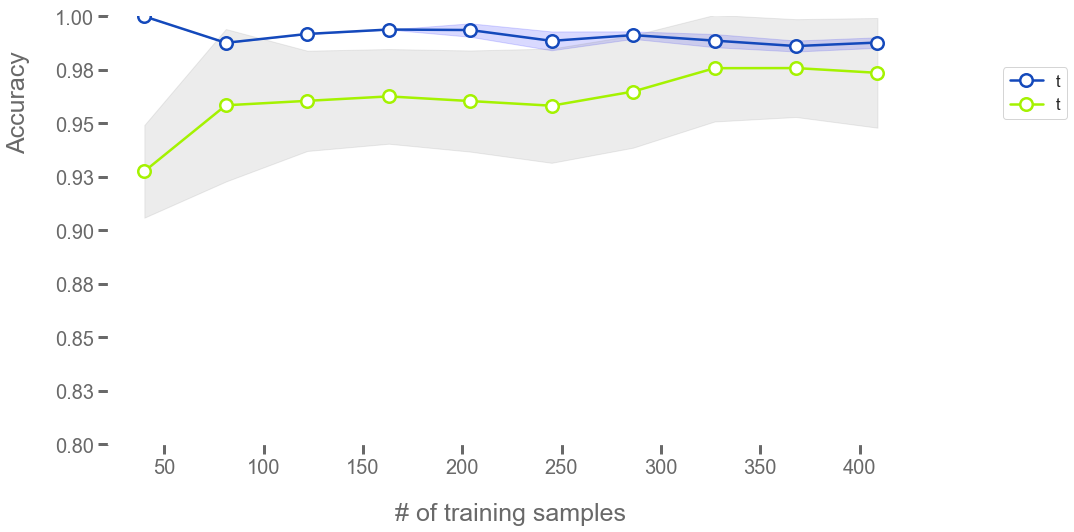

In [19]:


p = qp.QuickPlot(fig = plt.figure(), chartProp = 15)
ax = p.makeCanvas(xLabel = '# of training samples', yLabel = 'Accuracy', position = 111)

# Training accuracy
p.qpLine(x = train_sizes.reshape(-1,1)
               ,y = train_mean
               ,ax = ax
               ,markerOn = True
               ,label = 'training accuracy'
               ,yUnits = 'fff'
              )
plt.fill_between(train_sizes
                ,train_mean + train_std
                ,train_mean - train_std
                ,alpha=0.15, color='blue')

# Test accuracy
p.qpLine(x = train_sizes.reshape(-1,1)
               ,y = test_mean
               ,ax = ax
               ,markerOn = True
               ,linecolor = qp.qpStyle.qpColorsHexMid[1]
               ,label = 'test accuracy'
               ,yUnits = 'fff'
              )
plt.fill_between(train_sizes
                ,test_mean + test_std
                ,test_mean - test_std
                ,alpha=0.15, color='grey')


plt.ylim([0.8,1.0])
plt.grid()


<a id = ''></a>

# A

<a id = ''></a>

# A

<a id = ''></a>

# A

<a id = ''></a>

# A

<a id = ''></a>

# A

<a id = ''></a>

# A

<a id = ''></a>

# A

<a id = ''></a>

# A

<a id = ''></a>

# A

<a id = ''></a>

# A

<a id = ''></a>

# A